# Вариант 22

In [7]:
import sympy
import numpy as np
import control as ct
import control.matlab as ctm
import matplotlib.pyplot as plt

from IPython.display import display
from sympy import I

dt = 0.001

## Задание 1

рассмотрим $\ddot y + a_1 \dot y + a_0 y = u$

нейтральная и устойчивая апериодическая
пара устойчивых колебательных
пара неустойчивых колебательных

In [8]:
coeffs = [
    [0., 1.],
    [0.5, 1],
    [0.5, -1]
]

In [9]:
sec = 30
time = np.linspace(0, sec, int(sec/dt))
u = [
    np.ones_like(time)*1.5,
    time*0.6,
    np.cos(7*time)
]

In [10]:
init_states = [
    [-1, 0],
    [0, 0],
    [1, 0]
]

In [11]:
ss = [
    ct.tf2ss(
        [1.],
        [1., a[1], a[0]]
    ) for a in coeffs
]

In [12]:
y = {}

for i in range(len(ss)):
    inp_responses = {}
    for j in range(len(u)):
        inp_responses[f'input {j}'] =[
            ct.forced_response(
                ss[i],
                T=time,
                U=u[j],
                X0=state
            ) for state in init_states
        ]
    y[f'system {i}'] = inp_responses

In [13]:
from pprint import pprint

pprint(y)

{'system 0': {'input 0': [<control.timeresp.TimeResponseData object at 0x0000025389E48E20>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x00000253CA357100>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x00000253CA357BB0>,
                          <control.timeresp.TimeResponseData object at 0x00000253CA357580>]},
 'system 1': {'input 0': [<control.timeresp.TimeResponseData object at 0x00000253CA357220>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x00000253CA357F10>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x000002538A23F790>,
                          <control.timeresp.TimeResponseData object at 0x000002538A23FD90>]},
 'system 2': {'input 0': [<control.timeresp.TimeResponseData object at 0x000002538A23F7C0>,
              'input 1': [<control.timeresp.TimeResponseData object at 0x0000025388C0CFA0>,
              'input 2': [<control.timeresp.TimeResponseData object at 0x000

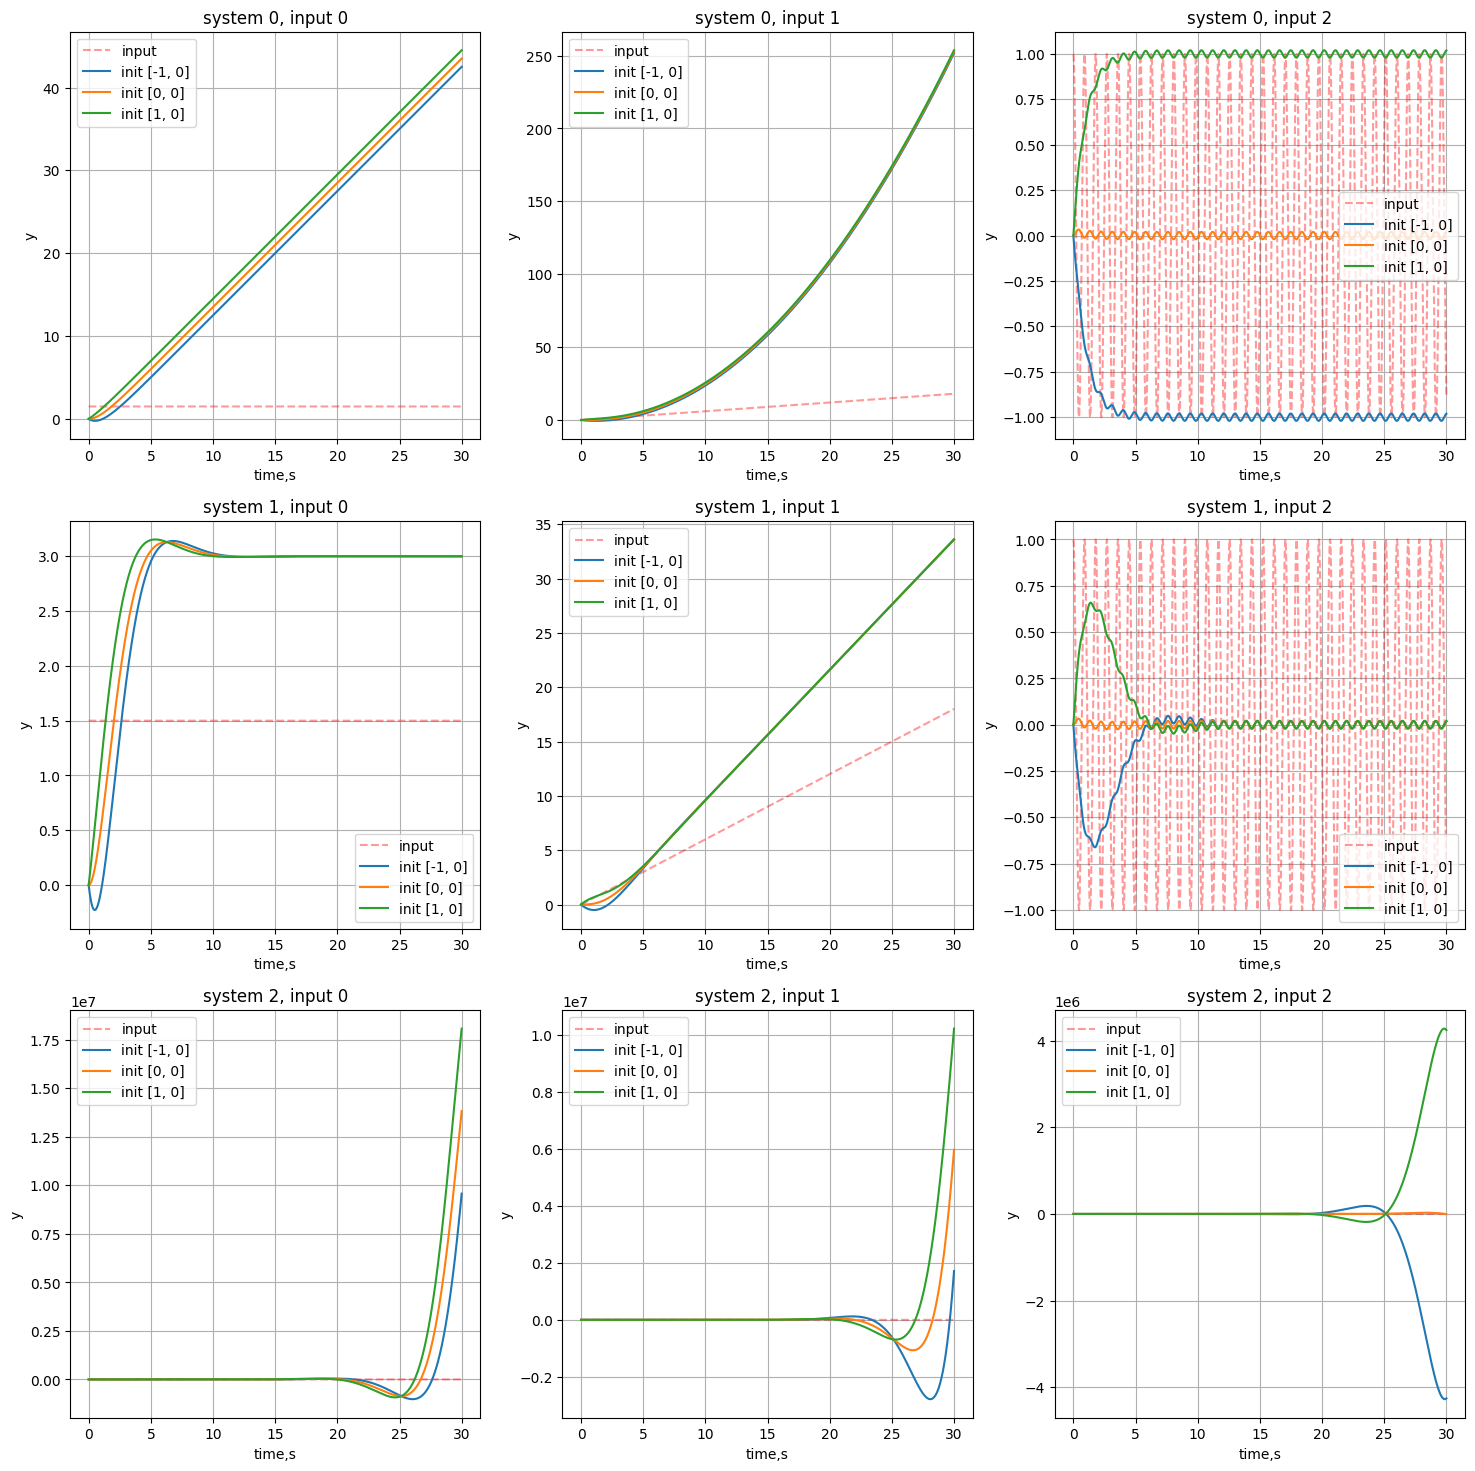

In [14]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize = (18, 18)
)

for i in range(len(y)):
    s = y[f'system {i}']
    
    for j in range(len(s)):    
        ax[i, j].set_title(f'system {i}, input {j}')
        ax[i, j].plot(time, u[j], "r--", alpha=0.4, label="input")
        ax[i, j].plot(time, s[f'input {j}'][0].outputs, label=f"init {init_states[0]}")
        ax[i, j].plot(time, s[f'input {j}'][1].outputs, label=f"init {init_states[1]}")
        ax[i, j].plot(time, s[f'input {j}'][2].outputs, label=f"init {init_states[2]}")
        
        ax[i,j].grid(True)
        ax[i,j].legend()
        ax[i,j].set_xlabel("time,s")
        ax[i,j].set_ylabel("y")

## Задание 2

In [137]:
lambdas = [
    -0.5+0.5j,
    -0.5-0.5j,
    -0.5-15j
]

In [138]:
s, l1, l2, l3 = sympy.symbols(r's lambda_1 lambda_2 lambda_3')

In [139]:
tf2 = 1 / ( (s - l1) * (s - l2) * (s-l3) )
sympy.Poly(sympy.fraction(tf2)[1], s)

Poly(s**3 + (-lambda_1 - lambda_2 - lambda_3)*s**2 + (lambda_1*lambda_2 + lambda_1*lambda_3 + lambda_2*lambda_3)*s - lambda_1*lambda_2*lambda_3, s, domain='ZZ[lambda_1,lambda_2,lambda_3]')

In [140]:
sec = 10
time = np.linspace(0, sec, int(sec/dt))
u = np.ones_like(time)
init_state2 = 0

In [141]:
s2 = ct.tf2ss(
    [1.],
    [1, -lambdas[0]-lambdas[1]-lambdas[2],
     lambdas[0]*lambdas[1] + lambdas[0]*lambdas[2] + lambdas[1]*lambdas[2],
     -lambdas[0]*lambdas[1]*lambdas[2]
     ]
)

In [142]:
y2 = ct.forced_response(
    s2,
    T=time,
    U=u,
    X0=init_state2
)

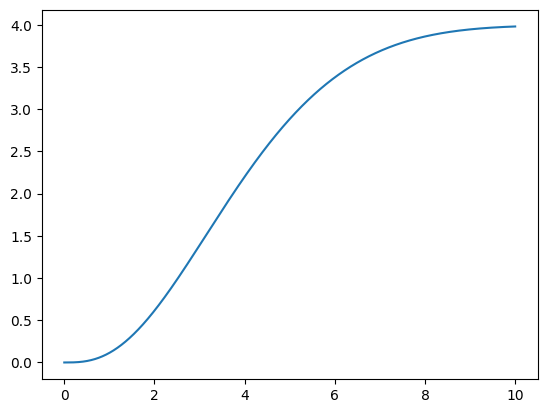

In [143]:
plt.plot(time, y2.outputs)